In [10]:
# Cell 0 – ONE-SHOT environment (CPU, Colab)
%%bash
pip install -q --upgrade pip

pip install -q numpy==1.26.4 protobuf==4.25.3

pip install -q \
    torch==2.2.0+cpu torchdata==0.7.1 \
    -f https://download.pytorch.org/whl/torch_stable.html

pip install -q dgl==2.1.0 dglgraphbolt==0.2.0

pip install -q tensorflow==2.16.1 \
    scikit-learn imbalanced-learn seaborn matplotlib pandas \
    chembl_webresource_client

# remove TF-addons that pin TF 2.18
pip uninstall -y -q tf-keras tensorflow-text tensorflow-decision-forests ydf jax


ERROR: Could not find a version that satisfies the requirement dglgraphbolt==0.2.0 (from versions: none)
ERROR: No matching distribution found for dglgraphbolt==0.2.0


In [1]:
import numpy, torch, tensorflow as tf, pandas as pd
print("NumPy", numpy.__version__)        # 1.26.4
print("Torch", torch.__version__)         # 2.2.0+cpu
print("TF   ", tf.__version__)            # 2.16.1


NumPy 1.26.4
Torch 2.2.0+cpu
TF    2.16.1


In [3]:
# Cell 2 ── pull from ChEMBL, label, deduplicate, save merged CSV
!pip install --quiet chembl_webresource_client
from chembl_webresource_client.new_client import new_client
from functools import reduce
import numpy as np
import pandas as pd

SAMPLE_SIZE = 12_000
activity     = new_client.activity

def fetch_herg():
    rows = activity.filter(target_chembl_id='CHEMBL240',
                           standard_type='IC50',
                           standard_units='nM')[:SAMPLE_SIZE]
    df   = pd.DataFrame(rows)[['molecule_chembl_id','canonical_smiles',
                               'standard_value','standard_units']]\
           .dropna(subset=['canonical_smiles','standard_value'])
    df['herg_ic50_nM'] = df['standard_value'].astype(float)
    df['herg_label']   = df['herg_ic50_nM'].apply(
            lambda x: 1 if x<=10_000 else 0 if x>40_000 else np.nan)
    df.drop(columns=['standard_value','standard_units'], inplace=True)
    return df.dropna(subset=['herg_label']).drop_duplicates('canonical_smiles')

def fetch_cyto():
    rows = activity.filter(assay_type='F',
                           target_cell__in=['HepG2','NIH/3T3','HeLa'],
                           standard_type__in=['IC50','EC50'])[:SAMPLE_SIZE]
    df = pd.DataFrame(rows)[['molecule_chembl_id','canonical_smiles',
                             'standard_value','standard_units']]\
         .dropna(subset=['canonical_smiles','standard_value'])
    def to_nM(v,u):
        v=float(v); return v*1000 if u in ['uM','μM'] else v if u=='nM' else np.nan
    df['cyto_value_nM'] = [to_nM(v,u) for v,u in zip(df.standard_value,df.standard_units)]
    df['cyto_label']    = df['cyto_value_nM'].apply(
            lambda x: 1 if x<=1_000 else 0 if x>10_000 else np.nan)
    df.drop(columns=['standard_value','standard_units'], inplace=True)
    return df.dropna(subset=['cyto_label']).drop_duplicates('canonical_smiles')

herg_data = fetch_herg();  cyto_data = fetch_cyto()
merged   = reduce(lambda l,r: pd.merge(l,r,on=['molecule_chembl_id','canonical_smiles'],
                                       how='outer'), [herg_data, cyto_data])
merged.to_csv('merged_toxicity_data.csv', index=False)
print("hERG:", herg_data.shape, "Cyto:", cyto_data.shape,
      "Merged:", merged.shape)


hERG: (7059, 4) Cyto: (4418, 4) Merged: (11444, 6)


In [4]:
# Cell 3  (add) ── overview of NA + duplicates
df = merged
print(df.isnull().mean().mul(100).round(2))
print("Duplicates:", df.duplicated("canonical_smiles").sum())


molecule_chembl_id     0.00
canonical_smiles       0.00
herg_ic50_nM          38.32
herg_label            38.32
cyto_value_nM         61.39
cyto_label            61.39
dtype: float64
Duplicates: 0


In [5]:
# Cell 4 ── build herg_clean.csv & cyto_clean.csv
from sklearn.preprocessing import StandardScaler
import numpy as np, pandas as pd

# hERG
h = df.dropna(subset=['herg_label']).copy()
h['log_ic50']  = np.log10(h['herg_ic50_nM'] + 1)
lower, upper   = np.percentile(h['log_ic50'], [1,99])
h['scaled_log_ic50'] = StandardScaler().fit_transform(
        h['log_ic50'].clip(lower,upper).values.reshape(-1,1))
h.to_csv("herg_clean.csv", index=False)

# Cyto
c = df.dropna(subset=['cyto_label']).copy()
c['log_cyto']  = np.log10(c['cyto_value_nM'] + 1)
l,u            = np.percentile(c['log_cyto'], [1,99])
c['scaled_log_cyto'] = StandardScaler().fit_transform(
        c['log_cyto'].clip(l,u).values.reshape(-1,1))
c.to_csv("cyto_clean.csv", index=False)

print("Saved: hERG", h.shape, "Cyto", c.shape)


Saved: hERG (7059, 8) Cyto (4418, 8)


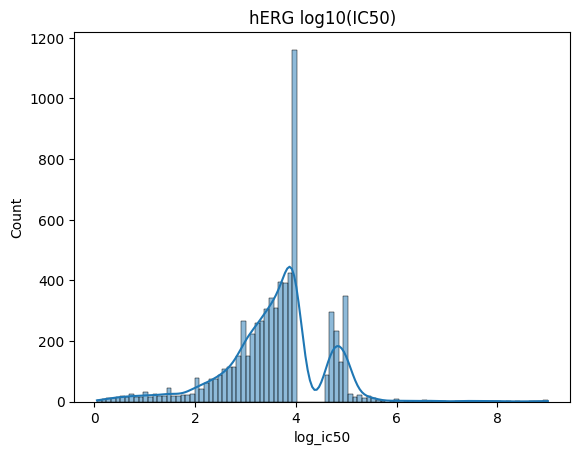

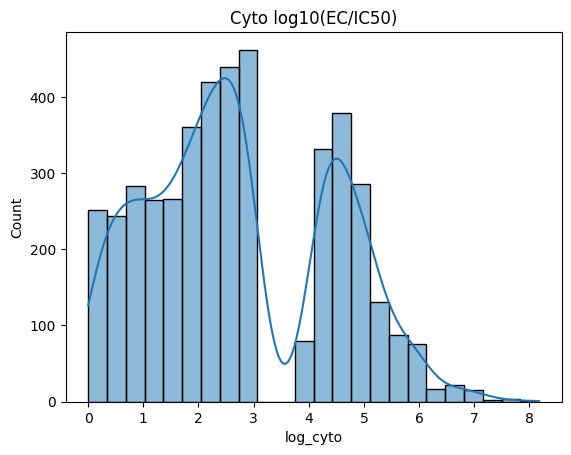

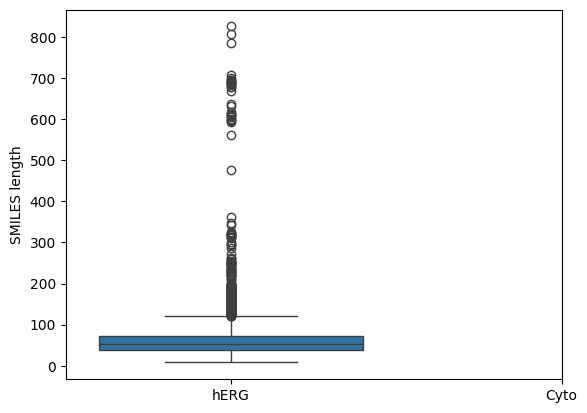

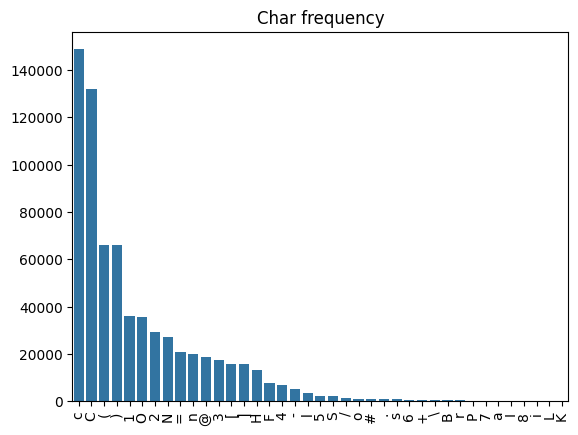

In [6]:
# Cell 5 (add) ── distributions, length, char-freq

import seaborn as sns, matplotlib.pyplot as plt
sns.histplot(h['log_ic50'], kde=True); plt.title("hERG log10(IC50)"); plt.show()
sns.histplot(c['log_cyto'], kde=True); plt.title("Cyto log10(EC/IC50)"); plt.show()

h_len = h['canonical_smiles'].str.len(); c_len = c['canonical_smiles'].str.len()
sns.boxplot(data=[h_len,c_len]); plt.xticks([0,1],['hERG','Cyto']); plt.ylabel("SMILES length"); plt.show()

from collections import Counter
vocab_counter = Counter("".join(pd.concat([h['canonical_smiles'], c['canonical_smiles']])))
chars, freqs  = zip(*vocab_counter.most_common())
sns.barplot(x=list(chars), y=list(freqs)); plt.xticks(rotation=90); plt.title("Char frequency"); plt.show()


In [5]:
# Classical ML baselines  ✅  (add missing import line)

from sklearn import model_selection      # ← add this
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report,
                             roc_auc_score,
                             average_precision_score)

SEED = 42
herg = pd.read_csv("herg_clean.csv")
cyto = pd.read_csv("cyto_clean.csv")

tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2,5), max_features=4096)
tfidf.fit(pd.concat([herg['canonical_smiles'], cyto['canonical_smiles']]))

def run_baseline(df, label, tag, thresh=0.60):
    X = tfidf.transform(df['canonical_smiles'])
    y = df[label].astype(int).values
    Xtr, Xte, ytr, yte = model_selection.train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=SEED)

    models = {
        "RF":  RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                      random_state=SEED,
                                      class_weight="balanced"),
        "SVM": SVC(kernel='rbf', probability=True, random_state=SEED,
                   class_weight="balanced")
    }
    for name, clf in models.items():
        clf.fit(Xtr, ytr)
        prob = clf.predict_proba(Xte)[:, 1]
        pred = (prob >= thresh).astype(int)
        print(f"\n— {tag} {name} —  (threshold={thresh})")
        print(classification_report(yte, pred, digits=4))
        print("ROC-AUC", roc_auc_score(yte, prob).round(3),
              "PR-AUC", average_precision_score(yte, prob).round(3))

run_baseline(herg, 'herg_label', "hERG")
run_baseline(cyto, 'cyto_label', "Cyto")



— hERG RF —  (threshold=0.6)
              precision    recall  f1-score   support

           0     0.7944    0.5652    0.6605       253
           1     0.9107    0.9681    0.9385      1159

    accuracy                         0.8959      1412
   macro avg     0.8526    0.7666    0.7995      1412
weighted avg     0.8899    0.8959    0.8887      1412

ROC-AUC 0.897 PR-AUC 0.969

— hERG SVM —  (threshold=0.6)
              precision    recall  f1-score   support

           0     0.6983    0.6680    0.6828       253
           1     0.9282    0.9370    0.9326      1159

    accuracy                         0.8888      1412
   macro avg     0.8133    0.8025    0.8077      1412
weighted avg     0.8870    0.8888    0.8878      1412

ROC-AUC 0.89 PR-AUC 0.964

— Cyto RF —  (threshold=0.6)
              precision    recall  f1-score   support

           0     0.7879    0.8182    0.8027       286
           1     0.9114    0.8946    0.9030       598

    accuracy                         0

In [7]:
# Cell 7 – build / re-build the vectoriser  ✅

import tensorflow as tf
from tensorflow.keras import layers        # ← add this import

MAX_LEN = 256        # longer to avoid truncating big SMILES

vectorizer = layers.TextVectorization(
    split="character",
    standardize=None,
    output_mode="int",
    output_sequence_length=MAX_LEN)

# adapt on the full SMILES corpus
vectorizer.adapt(pd.concat([herg['canonical_smiles'],
                            cyto['canonical_smiles']]))
VOCAB_SIZE = len(vectorizer.get_vocabulary())
print("Vectoriser ready, vocab size:", VOCAB_SIZE)


Vectoriser ready, vocab size: 41


In [10]:
# Cell 8 – Bi-LSTM training (no indentation errors)

import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn import model_selection

# uses the vectorizer & VOCAB_SIZE created in Cell 7
# ────────────────────────────────────────────────────────────
def build_lstm(vocab_size, emb_dim=128, lstm_units=64):
    inp = layers.Input(shape=(1,), dtype=tf.string)
    x   = vectorizer(inp)                                   # len = 256
    x   = layers.Embedding(vocab_size, emb_dim, mask_zero=True)(x)
    x   = layers.Bidirectional(layers.LSTM(lstm_units))(x)
    x   = layers.Dense(64, activation="relu")(x)
    x   = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ],
    )
    return model


def train_lstm(df, label_col, save_name, epochs=12):
    # 80/20 split
    X_tr, X_te = model_selection.train_test_split(
        df,
        test_size=0.2,
        stratify=df[label_col],
        random_state=SEED,
    )

    # tf.data pipelines
    ds_tr = (
        tf.data.Dataset.from_tensor_slices(
            (X_tr["canonical_smiles"], X_tr[label_col].astype(int))
        )
        .shuffle(8192, SEED)
        .batch(64)
        .prefetch(tf.data.AUTOTUNE)
    )
    ds_te = tf.data.Dataset.from_tensor_slices(
        (X_te["canonical_smiles"], X_te[label_col].astype(int))
    ).batch(64)

    # gentler class weights
    counts = X_tr[label_col].value_counts()
    cw = {
        0: len(X_tr) / counts[0] * 0.8,   # safe weight ×0.8
        1: len(X_tr) / counts[1],         # toxic weight ×1
    }

    model = build_lstm(VOCAB_SIZE)
    es = callbacks.EarlyStopping(patience=4, restore_best_weights=True)

    model.fit(
        ds_tr,
        validation_data=ds_te,
        epochs=epochs,
        callbacks=[es],
        class_weight=cw,
        verbose=2,
    )

    model.save(f"{save_name}.keras")
    return model, X_te


# ── train both endpoints ────────────────────────────────────
herg_model, Xh_te = train_lstm(herg, "herg_label", "herg_lstm")
cyto_model, Xc_te = train_lstm(cyto, "cyto_label", "cyto_lstm")


Epoch 1/12
89/89 - 59s - 667ms/step - auc: 0.6559 - loss: 1.1660 - precision: 0.8510 - recall: 0.8688 - val_auc: 0.7554 - val_loss: 0.4626 - val_precision: 0.8847 - val_recall: 0.8740
Epoch 2/12
89/89 - 53s - 601ms/step - auc: 0.7540 - loss: 1.0513 - precision: 0.8963 - recall: 0.8043 - val_auc: 0.7479 - val_loss: 0.6050 - val_precision: 0.9058 - val_recall: 0.6972
Epoch 3/12
89/89 - 82s - 922ms/step - auc: 0.7573 - loss: 1.0423 - precision: 0.9009 - recall: 0.7890 - val_auc: 0.7626 - val_loss: 0.4888 - val_precision: 0.8896 - val_recall: 0.8550
Epoch 4/12
89/89 - 80s - 895ms/step - auc: 0.7720 - loss: 1.0172 - precision: 0.9026 - recall: 0.8101 - val_auc: 0.7588 - val_loss: 0.4981 - val_precision: 0.8765 - val_recall: 0.8637
Epoch 5/12
89/89 - 52s - 584ms/step - auc: 0.7969 - loss: 0.9738 - precision: 0.9110 - recall: 0.8198 - val_auc: 0.7798 - val_loss: 0.4510 - val_precision: 0.8899 - val_recall: 0.8783
Epoch 6/12
89/89 - 83s - 931ms/step - auc: 0.7941 - loss: 0.9740 - precision: 0.

In [11]:
# Cell 9 – Char-GCN for hERG *and* Cyto  (no DGL, pure PyTorch)
import torch, torch.nn.functional as F, random
from sklearn import metrics, model_selection

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- helper: SMILES → graph -------------------------------------
def smiles_to_graph(smiles):
    ints  = vectorizer([smiles]).numpy()[0]
    mask  = ints != 0
    x     = torch.tensor(ints[mask], dtype=torch.long)           # (n,)
    n     = len(x)
    if n == 0:                                                   # guard
        x = torch.tensor([1], dtype=torch.long); n = 1
    src   = torch.arange(n-1, dtype=torch.long)
    dst   = torch.arange(1, n, dtype=torch.long)
    ei    = torch.cat([torch.stack([src,dst],0),
                       torch.stack([dst,src],0)], 1)             # (2,E)
    return x, ei

# ---------- one-layer message-passing ----------------------------------
class ChainMP(torch.nn.Module):
    def __init__(self, vocab, emb_dim, out_dim):
        super().__init__()
        self.emb = torch.nn.Embedding(vocab, emb_dim, padding_idx=0)
        self.lin = torch.nn.Linear(emb_dim, out_dim, bias=False)
    def forward(self, x, ei):
        h = self.emb(x)
        row, col = ei
        agg = torch.zeros_like(h)
        agg.index_add_(0, row, h[col])       # neighbour sum
        return F.relu(self.lin(agg))

class CharGCN(torch.nn.Module):
    def __init__(self, vocab, emb=64, hid=128):
        super().__init__()
        self.mp  = ChainMP(vocab, emb, hid)
        self.out = torch.nn.Linear(hid, 1)
    def forward(self, graphs):
        feats = []
        for x, ei in graphs:
            h = self.mp(x.to(device), ei.to(device))
            feats.append(h.mean(0))          # global mean pool
        feats = torch.stack(feats)           # (batch, hid)
        return torch.sigmoid(self.out(feats)).squeeze(1)

# ---------- training loop ---------------------------------------------
def train_char_gcn(df, label, epochs=5, batch=64):
    data = [(smiles_to_graph(s), y)
            for s, y in zip(df['canonical_smiles'], df[label].astype(float))]
    net  = CharGCN(VOCAB_SIZE).to(device)
    opt  = torch.optim.Adam(net.parameters(), lr=1e-3)
    for ep in range(epochs):
        random.shuffle(data)
        losses = []
        for i in range(0, len(data), batch):
            graphs, ys = zip(*data[i:i+batch])
            pred = net(graphs)
            y    = torch.tensor(ys, dtype=torch.float32, device=device)
            loss = F.binary_cross_entropy(pred, y)
            opt.zero_grad(); loss.backward(); opt.step()
            losses.append(loss.item())
        print(f"Epoch {ep+1}/{epochs}  loss {sum(losses)/len(losses):.4f}")
    return net

# ---------- evaluation helper -----------------------------------------
def eval_char_gcn(model, df, label, name, thresh=0.60):
    _, df_te = model_selection.train_test_split(
        df, test_size=0.2, stratify=df[label], random_state=SEED)
    graphs = [smiles_to_graph(s) for s in df_te['canonical_smiles']]
    with torch.no_grad():
        prob = model(graphs).cpu().numpy()
    y_true = df_te[label].values.astype(int)
    y_pred = (prob >= thresh).astype(int)
    print(f"\n{name} CharGCN  (threshold={thresh})")
    print(metrics.classification_report(y_true, y_pred, digits=4))
    print("Confusion matrix:\n", metrics.confusion_matrix(y_true, y_pred))
    print("ROC-AUC:", metrics.roc_auc_score(y_true, prob).round(3),
          "PR-AUC:", metrics.average_precision_score(y_true, prob).round(3))

# ---------- train & evaluate hERG -------------------------------------
print("Training hERG CharGCN...")
gnn_herg = train_char_gcn(herg.sample(4000, random_state=SEED), 'herg_label')
eval_char_gcn(gnn_herg, herg, 'herg_label', "hERG")

# ---------- train & evaluate Cyto -------------------------------------
print("\nTraining Cyto CharGCN...")
gnn_cyto = train_char_gcn(cyto.sample(4000, random_state=SEED), 'cyto_label')
eval_char_gcn(gnn_cyto, cyto, 'cyto_label', "Cyto")


Training hERG CharGCN...
Epoch 1/5  loss 0.4644
Epoch 2/5  loss 0.4285
Epoch 3/5  loss 0.4109
Epoch 4/5  loss 0.4016
Epoch 5/5  loss 0.3977

hERG CharGCN  (threshold=0.6)
              precision    recall  f1-score   support

           0     0.6296    0.1344    0.2215       253
           1     0.8387    0.9827    0.9050      1159

    accuracy                         0.8307      1412
   macro avg     0.7342    0.5586    0.5633      1412
weighted avg     0.8013    0.8307    0.7826      1412

Confusion matrix:
 [[  34  219]
 [  20 1139]]
ROC-AUC: 0.755 PR-AUC: 0.916

Training Cyto CharGCN...
Epoch 1/5  loss 0.6230
Epoch 2/5  loss 0.6052
Epoch 3/5  loss 0.5925
Epoch 4/5  loss 0.5859
Epoch 5/5  loss 0.5800

Cyto CharGCN  (threshold=0.6)
              precision    recall  f1-score   support

           0     0.6343    0.3881    0.4816       286
           1     0.7532    0.8930    0.8171       598

    accuracy                         0.7296       884
   macro avg     0.6937    0.6405    

Best thresholds  hERG=0.30   Cyto=0.55

hERG LSTM  (threshold=0.30)
              precision    recall  f1-score   support

         0.0     0.7009    0.2964    0.4167       253
         1.0     0.8636    0.9724    0.9148      1159

    accuracy                         0.8513      1412
   macro avg     0.7823    0.6344    0.6657      1412
weighted avg     0.8345    0.8513    0.8255      1412

Confusion matrix:
 [[  75  178]
 [  32 1127]]
ROC-AUC: 0.805  PR-AUC: 0.936

Cyto  LSTM  (threshold=0.55)
              precision    recall  f1-score   support

         0.0     0.7016    0.6084    0.6517       286
         1.0     0.8239    0.8763    0.8493       598

    accuracy                         0.7896       884
   macro avg     0.7628    0.7423    0.7505       884
weighted avg     0.7843    0.7896    0.7853       884

Confusion matrix:
 [[174 112]
 [ 74 524]]
ROC-AUC: 0.821  PR-AUC: 0.902


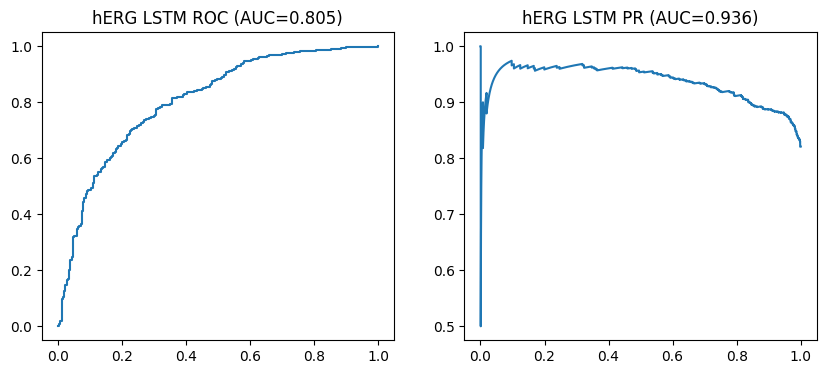

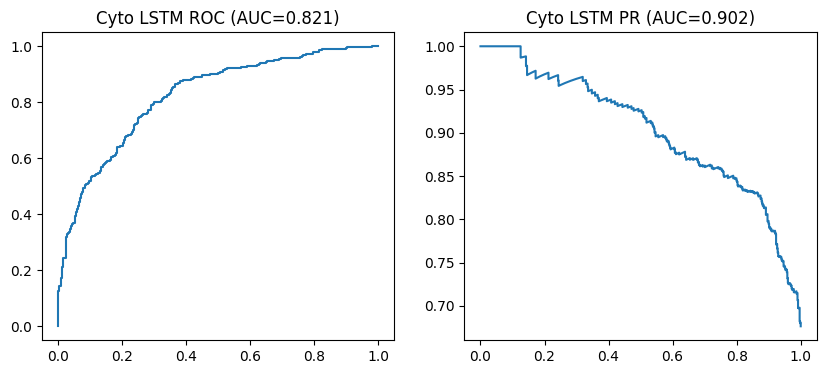

In [12]:
# Cell 10 ── evaluate LSTM models with auto-tuned threshold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def eval_probs(model, smiles):
    return model.predict(tf.constant(smiles.values), verbose=0).ravel()

yh_prob = eval_probs(herg_model, Xh_te['canonical_smiles'])
yc_prob = eval_probs(cyto_model, Xc_te['canonical_smiles'])

# ---------- find F1-max thresholds FIRST ------------------------------
def best_thresh(y, p):
    th = np.linspace(0.10, 0.90, 17)
    f1 = [metrics.f1_score(y, p >= t) for t in th]
    return th[int(np.argmax(f1))]

BEST_HERG = best_thresh(Xh_te['herg_label'],  yh_prob)
BEST_CYTO = best_thresh(Xc_te['cyto_label'], yc_prob)
print(f"Best thresholds  hERG={BEST_HERG:.2f}   Cyto={BEST_CYTO:.2f}")

# ---------- numeric summary with tuned thresholds ---------------------
def eval_binary(y_true, prob, name, thresh):
    pred = (prob >= thresh).astype(int)
    print(f"\n{name}  (threshold={thresh:.2f})")
    print(metrics.classification_report(y_true, pred, digits=4))
    print("Confusion matrix:\n", metrics.confusion_matrix(y_true, pred))
    print("ROC-AUC:", metrics.roc_auc_score(y_true, prob).round(3),
          " PR-AUC:", metrics.average_precision_score(y_true, prob).round(3))

eval_binary(Xh_te['herg_label'], yh_prob, "hERG LSTM", BEST_HERG)
eval_binary(Xc_te['cyto_label'], yc_prob, "Cyto  LSTM", BEST_CYTO)

# ---------- ROC & PR plots (unchanged) --------------------------------
def plot_roc_pr(y_true, prob, title):
    fpr,tpr,_ = metrics.roc_curve(y_true, prob)
    prec,rec,_= metrics.precision_recall_curve(y_true, prob)
    fig,ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(fpr,tpr); ax[0].set_title(f"{title} ROC (AUC={metrics.auc(fpr,tpr):.3f})")
    ax[1].plot(rec,prec);ax[1].set_title(f"{title} PR (AUC={metrics.average_precision_score(y_true,prob):.3f})")
    plt.show()

plot_roc_pr(Xh_te['herg_label'], yh_prob, "hERG LSTM")
plot_roc_pr(Xc_te['cyto_label'], yc_prob, "Cyto LSTM")


In [18]:
# diagnostic snippet — works with 1-D tensor
import tensorflow as tf, pubchempy as pcp

def name_to_smiles(name):
    try:
        c = pcp.get_compounds(name, "name")
        return c[0].isomeric_smiles if c else None
    except Exception:
        return None

test_name = "terfenadine"
smiles    = name_to_smiles(test_name)
print("Resolved SMILES:", smiles)

if smiles:
    # 1-D tensor: shape (1,), dtype string
    prob = float(herg_model.predict(
                 tf.constant([smiles], dtype=tf.string))[0, 0])
    print("Raw hERG probability:", prob)

    tokens = vectorizer([smiles])[0][:20]
    print("Vectorised tokens:", tokens.numpy())
else:
    print("SMILES lookup failed.")


Resolved SMILES: CC(C)(C)C1=CC=C(C=C1)C(CCCN2CCC(CC2)C(C3=CC=CC=C3)(C4=CC=CC=C4)O)O
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Raw hERG probability: 0.227346271276474
Vectorised tokens: [ 3  3  5  3  4  5  3  4  3  6 10  3  3 10  3  5  3 10  3  6]


In [ ]:
# Cell 11 – deployment with grey zone
!pip install -q gradio pubchempy requests

import gradio as gr, pubchempy as pcp, requests, urllib.parse, tensorflow as tf

BEST_HERG = 0.15          # ← copy from Cell 10 output
BEST_CYTO = 0.20
LOW, HIGH = 0.40, 0.60    # grey-zone band stays as you like

def name_to_smiles(name):
    name=name.strip()
    try:
        res = pcp.get_compounds(name,"name")
        if res: return res[0].isomeric_smiles
    except: pass
    try:
        url=("https://www.ebi.ac.uk/chembl/api/data/molecule/search"
             f"?q={urllib.parse.quote(name)}&format=json&limit=1")
        r=requests.get(url,timeout=5).json()
        if r["molecules"]:
            return r["molecules"][0]["molecule_structures"]["canonical_smiles"]
    except: pass
    return None

herg_model = tf.keras.models.load_model("herg_lstm.keras")
cyto_model = tf.keras.models.load_model("cyto_lstm.keras")

def predict(name, endpoint):
    smi = name_to_smiles(name)
    if not smi: raise gr.Error("Name → SMILES failed.")
    m   = herg_model if endpoint=="hERG" else cyto_model
    t   = BEST_HERG if endpoint=="hERG" else BEST_CYTO
    prob = float(m.predict(tf.constant([[smi]]))[0,0])

    if prob < LOW:          label = "Non-Toxic"
    elif prob > HIGH:       label = "Toxic"
    else:                   label = "Uncertain"

    return {label: f"{prob:.3f}"}

iface = gr.Interface(
    fn=predict,
    inputs=[gr.Textbox(label="Chemical name"),
            gr.Radio(["hERG","Cyto"], label="Endpoint")],
    outputs=gr.JSON(),
    title="Toxicity predictor",
    description=f"Safe < {LOW}  |  Grey {LOW}-{HIGH}  |  Toxic > {HIGH}")
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6f47ac460fa2fd6279.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [20]:
# run this after name_to_smiles, vectorizer, and herg_model exist
test_names = [
    "terfenadine", "cisapride", "astemizole", "dofetilide",
    "quinidine",  "ibutilide", "ziprasidone", "sertindole",
    "haloperidol", "pimozide"
]

for n in test_names:
    smi = name_to_smiles(n)
    if smi:
        # 1-D tensor, dtype must be tf.string
        prob = float(
            herg_model.predict(tf.constant([smi], dtype=tf.string))[0, 0]
        )
        status = "OK"
    else:
        prob   = None
        status = "FAIL"
    print(f"{n:12s}  SMILES? {status}   prob={prob}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
terfenadine   SMILES? OK   prob=0.227346271276474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
cisapride     SMILES? OK   prob=0.04740278422832489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
astemizole    SMILES? OK   prob=0.4975128769874573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
dofetilide    SMILES? OK   prob=0.05174075439572334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
quinidine     SMILES? OK   prob=0.09220919013023376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
ibutilide     SMILES? OK   prob=0.1608690470457077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
ziprasidone   SMILES? OK   prob=0.18809835612773895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
sertindole    SMILES? OK   prob=0.20637792348861694
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
haloperidol   SMILES? OK   prob=0.08493396639823914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
pimozide      SMILES? OK   prob=0.11402811110019684
